# Source Injector (Extended Source Example)

<div class="alert alert-block alert-info">
The source injector can produce mock simulated data independent of the MEGAlib software.

Standard data simulation requires the users to install and use MEGAlib to convolve the source model with the detector effects to generate data. The source injector utilizes the response generated by intensive simulation, which contains the statistical detector effects. With the source injector, you can convolve response, source model, and orientation to gain the mock data quickly. 

The advantages of using the source injector include:

- No need to install and use MEGAlib
- Get the data much faster than the standard simulation pipeline
- The generated data are in the format that can be used for spectral fitting, localization, imaging, etc.

The disadvantages are:

- The data are binned based on the binning of the response, which means that you lost the unbinned event distribution as you will get from the MEGAlib pipeline.
- If the response is coarse, the data you generated might not be precise.

In [1]:
%%capture

import os
import shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import healpy as hp
from scipy.interpolate import interp1d
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from scoords import SpacecraftFrame
from astromodels import Gaussian, Gaussian_on_sphere, ExtendedSource, Parameter
from astromodels.functions.function import Function1D, FunctionMeta
from cosipy import SpacecraftFile, SourceInjector
from cosipy.util import fetch_wasabi_file
from cosipy.threeml.custom_functions import Wide_Asymm_Gaussian_on_sphere, SpecFromDat
from threeML import Powerlaw, Band, PointSource, Model, ExtendedSource
from histpy import Histogram, Axis, Axes
from mhealpy import HealpixMap

%matplotlib inline

In [2]:
# To specify a different directory, use Path("your/directory/path").
data_dir = Path("/Users/shengyong/Research/COSi/Data_challenges/DC2")  # Current directory by default. Modify if you want a different path

## Get the data
The following cells allow you to download the required data. Each respective cell provides the Wasabi file path and file size. The data will only be downloaded if it is not already present in the specified directory.

Wasabi path: <code style="color:seagreen;">COSI-SMEX/DC2/Responses/PointSourceReponse/511_gal_DC2_earthocc_nooverflow.h5</code> <br />
File size: <code style="color:seagreen;">4.53 GB</code>

In [3]:
%%capture
response_path = data_dir / "511_gal_DC2_earthocc_nooverflow.h5"

if not response_path.exists():
    fetch_wasabi_file(
        "COSI-SMEX/DC2/Responses/PointSourceReponse/511_gal_DC2_earthocc_nooverflow.h5",
        response_path,
    )

Wasabi path: <code style="color:seagreen;">COSI-SMEX/DC2/Data/Sources/511_thin_disk_3months_binned_data.hdf5 </code> <br />
File size: <code style="color:seagreen;">140.3 MB</code>

In [4]:
%%capture
file_path = data_dir / "511_thin_disk_3months_binned_data.hdf5"

if not file_path.exists():
    fetch_wasabi_file(
        "COSI-SMEX/DC2/Data/Sources/511_thin_disk_3months_binned_data.hdf5",
        file_path,
    )

## Example 1: Simple Extended Source

### 1 : Define the extended source
This defines a simple extended source using `astromodels.ExtendedSource`, combining a Gaussian spectral shape centered at 511 keV with a Gaussian spatial model centered near the Galactic Center.

In [5]:
# Define spectrum:
# Note that the units of the Gaussian function below are [F/sigma]=[ph/cm2/s/keV]
F = 4e-2 / u.cm / u.cm / u.s
mu = 511 * u.keV
sigma = 0.85 * u.keV
spectrum = Gaussian()
spectrum.F.value = F.value
spectrum.F.unit = F.unit
spectrum.mu.value = mu.value
spectrum.mu.unit = mu.unit
spectrum.sigma.value = sigma.value
spectrum.sigma.unit = sigma.unit

# Set spectral parameters for fitting:
spectrum.F.free = True
spectrum.mu.free = False
spectrum.sigma.free = False

# Define morphology:
morphology = Gaussian_on_sphere(lon0=359.75, lat0=-1.25, sigma=5)

# Set morphological parameters for fitting:
morphology.lon0.free = False
morphology.lat0.free = False
morphology.sigma.free = False

# Define source:
gaussian_extended_source = ExtendedSource(
    "gaussian", spectral_shape=spectrum, spatial_shape=morphology
)

model = Model(gaussian_extended_source)

# Print a summary of the source info:
gaussian_extended_source.display()

* gaussian (extended source):
    * shape:
      * lon0:
        * value: 359.75
        * desc: Longitude of the center of the source
        * min_value: 0.0
        * max_value: 360.0
        * unit: deg
        * is_normalization: false
      * lat0:
        * value: -1.25
        * desc: Latitude of the center of the source
        * min_value: -90.0
        * max_value: 90.0
        * unit: deg
        * is_normalization: false
      * sigma:
        * value: 5.0
        * desc: Standard deviation of the Gaussian distribution
        * min_value: 0.0
        * max_value: 20.0
        * unit: deg
        * is_normalization: false
    * spectrum:
      * main:
        * Gaussian:
          * F:
            * value: 0.04
            * desc: Integral between -inf and +inf. Fix this to 1 to obtain a Normal distribution
            * min_value: null
            * max_value: null
            * unit: s-1 cm-2
            * is_normalization: false
          * mu:
            * value: 511.0
            * desc: Central value
            * min_value: null
            * max_value: null
            * unit: keV
            * is_normalization: false
          * sigma:
            * value: 0.85
            * desc: standard deviation
            * min_value: 1.0e-12
            * max_value: null
            * unit: keV
            * is_normalization: false
        * polarization: {}

Text(0.5, 0, 'Energy [keV]')

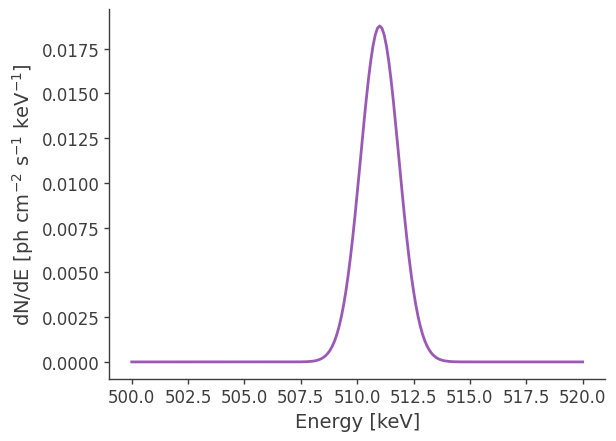

In [6]:
# Plot spectrum:
energy = np.linspace(500.,520.,201)*u.keV
dnde = gaussian_extended_source.spectrum.main.Gaussian(energy)
plt.plot(energy, dnde)
plt.ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
plt.xlabel("Energy [keV]", fontsize=14)

In [7]:
# Define healpix map matching the detector response:
skymap = HealpixMap(nside = 16, scheme = "ring", dtype = float, coordsys='G')
coords1 = skymap.pix2skycoord(range(skymap.npix))
pix_area = skymap.pixarea().value

# Fill skymap with values from extended source: 
skymap[:] = gaussian_extended_source.Gaussian_on_sphere(coords1.l.deg, coords1.b.deg) 

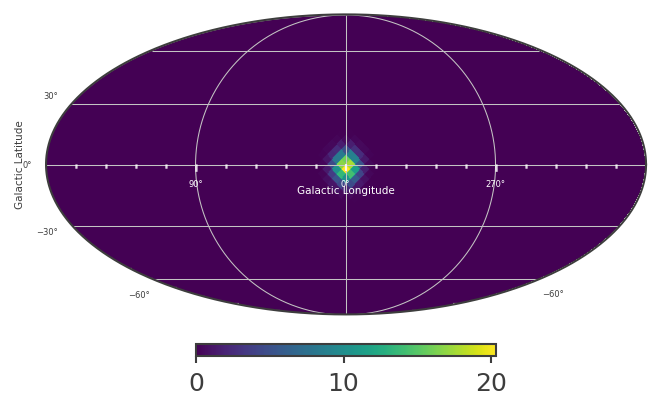

In [8]:
# Plot healpix map:
plot, ax = skymap.plot(ax_kw = {'coord':'G'})
ax.grid()
lon = ax.coords['glon']
lat = ax.coords['glat']
lon.set_axislabel('Galactic Longitude',color='white',fontsize=5)
lat.set_axislabel('Galactic Latitude',fontsize=5)
lon.display_minor_ticks(True)
lat.display_minor_ticks(True)
lon.set_ticks_visible(True)
lon.set_ticklabel_visible(True)
lon.set_ticks(color='white',alpha=0.6)
lat.set_ticks(color='white',alpha=0.6)
lon.set_ticklabel(color='white',fontsize=4)
lat.set_ticklabel(fontsize=4)
lat.set_ticks_visible(True)
lat.set_ticklabel_visible(True)

### 2. Initialize the Source Injector

In [9]:
# Initialize the SourceInjector (using galactic frame for extended sources)
injector = SourceInjector(response_path=response_path, response_frame = "galactic")

### 3. Get the expected counts for the extended source and save to a data file

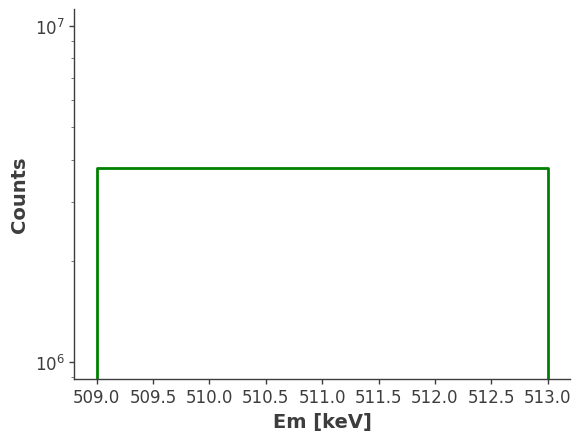

In [10]:
# Define the file path
file_path = "gaussian_extended_source.h5"
# Check if the file exists and remove it if it does
if os.path.exists(file_path):
    os.remove(file_path)

# Inject the extended source
model_injected = injector.inject_model(model = model, make_spectrum_plot = True, data_save_path = file_path)
plt.gca().set_xscale("linear")  # Set x-axis to linear
plt.show()

## Example 2: Working With a Realistic Model

### 1 : Define the extended source

This defines a multi-component source consisting of a central point source, a bulge (split into a narrow and broad component), and a disk. Each component has distinct spectral and spatial characteristics. Spatially, the bulge component is the sum of three different spatial models, with the majority of the flux concentrated in the **narrow bulge**, which has the smallest spatial extent. The **broad bulge** contributes additional emission over a wider region, while the **disk** extends along the Galactic plane. The **central point source** is located at the Galactic center and modeled as a single point source.

In [11]:
# Spectral Definitions...

models = ["centralPoint","narrowBulge","broadBulge","disk"]

# several lists of parameters for, in order, CentralPoint, NarrowBulge, BroadBulge, and Disk sources
mu         = [511.,511.,511., 511.]*u.keV
sigma      = [0.85,0.85,0.85, 1.27]*u.keV
F          = [0.00012, 0.00028, 0.00073, 1.7e-3]/u.cm/u.cm/u.s
K          = [0.00046, 0.0011, 0.0027, 4.5e-3]/u.cm/u.cm/u.s/u.keV

SpecLine   = [Gaussian(),Gaussian(),Gaussian(),Gaussian()]
SpecOPs    = [SpecFromDat(dat="OPsSpectrum.dat"),SpecFromDat(dat="OPsSpectrum.dat"),SpecFromDat(dat="OPsSpectrum.dat"),SpecFromDat(dat="OPsSpectrum.dat")]

# Set units and fitting parameters; different definition for each spectral model with different norms
for i in range(4):
    SpecLine[i].F.unit = F[i].unit
    SpecLine[i].F.value = F[i].value
    SpecLine[i].F.min_value =0
    SpecLine[i].F.max_value=1
    SpecLine[i].mu.value = mu[i].value
    SpecLine[i].mu.unit = mu[i].unit
    SpecLine[i].sigma.unit = sigma[i].unit
    SpecLine[i].sigma.value = sigma[i].value

    SpecOPs[i].K.value = K[i].value
    SpecOPs[i].K.unit = K[i].unit

    SpecLine[i].sigma.free = False
    SpecLine[i].mu.free = False
    SpecLine[i].F.free = False#True
    SpecOPs[i].K.free = False # not fitting the amplitude of the OPs component for now, since we are only using the 511 response!

SpecLine[-1].F.free = True# actually do fit the flux of the disk component

# Generate Composite Spectra
SpecCentralPoint= SpecLine[0] + SpecOPs[0]
SpecNarrowBulge = SpecLine[1] + SpecOPs[1]
SpecBroadBulge  = SpecLine[2] + SpecOPs[2]
SpecDisk        = SpecLine[3] + SpecOPs[3]

# Define Spatial Model Components
MapNarrowBulge = Gaussian_on_sphere(lon0=359.75,lat0=-1.25, sigma = 2.5)
MapBroadBulge = Gaussian_on_sphere(lon0 = 0, lat0 = 0, sigma = 8.7)
MapDisk = Wide_Asymm_Gaussian_on_sphere(lon0 = 0, lat0 = 0, a=90, e = 0.99944429,theta=0)

# Fix fitting parameters (same for all models)
for map in [MapNarrowBulge,MapBroadBulge]:
    map.lon0.free=False
    map.lat0.free=False
    map.sigma.free=False

MapDisk.lon0.free=False
MapDisk.lat0.free=False
MapDisk.a.free=False
MapDisk.e.free=True#False
MapDisk.theta.free=False

# Define Spatio-spectral models

# Bulge
c = SkyCoord(l=0*u.deg, b=0*u.deg, frame='galactic')
c_icrs = c.transform_to('icrs')
ModelCentralPoint = PointSource('centralPoint', ra = c_icrs.ra.deg, dec = c_icrs.dec.deg, spectral_shape=SpecCentralPoint)
ModelNarrowBulge = ExtendedSource('narrowBulge',spectral_shape=SpecNarrowBulge,spatial_shape=MapNarrowBulge)
ModelBroadBulge = ExtendedSource('broadBulge',spectral_shape=SpecBroadBulge,spatial_shape=MapBroadBulge)

# Disk
ModelDisk = ExtendedSource('disk',spectral_shape=SpecDisk,spatial_shape=MapDisk)

In [12]:
model = Model(ModelCentralPoint, ModelNarrowBulge, ModelBroadBulge, ModelDisk)

Make some plots to look at these extended sources:

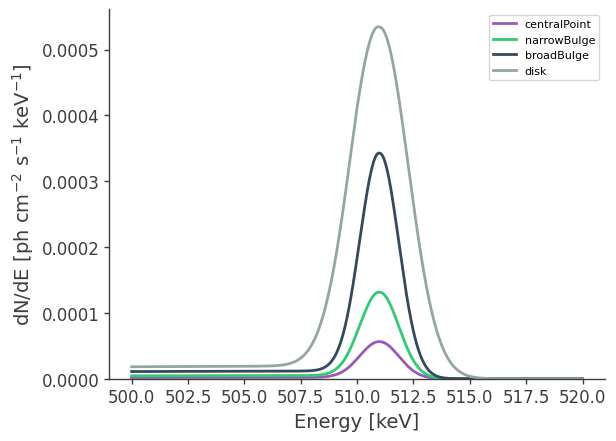

In [13]:
# Plot spectra at 511 keV
energy = np.linspace(500.,520.,10001)*u.keV
fig, axs = plt.subplots()
for label,m in zip(models,
                   [ModelCentralPoint,ModelNarrowBulge,ModelBroadBulge,ModelDisk]):
    dnde = m.spectrum.main.composite(energy)
    axs.plot(energy, dnde,label=label)

axs.legend()
axs.set_ylabel("dN/dE [$\mathrm{ph \ cm^{-2} \ s^{-1} \ keV^{-1}}$]", fontsize=14)
axs.set_xlabel("Energy [keV]", fontsize=14);
plt.ylim(0,);
#axs[0].set_yscale("log")

In [14]:
# Define healpix map matching the detector response:
nside_model = 2**4
scheme='ring'
is_nested = (scheme == 'nested')
coordsys='G'

mBroadBulge = HealpixMap(nside = nside_model, scheme = scheme, dtype = float,coordsys=coordsys)
mNarrowBulge = HealpixMap(nside = nside_model, scheme = scheme, dtype = float,coordsys=coordsys)
mPointBulge = HealpixMap(nside = nside_model, scheme = scheme, dtype = float,coordsys=coordsys)
mDisk = HealpixMap(nside = nside_model, scheme=scheme, dtype = float,coordsys=coordsys)

coords = mDisk.pix2skycoord(range(mDisk.npix)) # common among all the galactic maps...

pix_area = mBroadBulge.pixarea().value # common among all the galactic maps with the same pixelization

# Fill skymap with values from extended source:
mNarrowBulge[:] = ModelNarrowBulge.spatial_shape(coords.l.deg, coords.b.deg)
mBroadBulge[:] = ModelBroadBulge.spatial_shape(coords.l.deg, coords.b.deg)
mBulge = mBroadBulge + mNarrowBulge
mDisk[:] = ModelDisk.spatial_shape(coords.l.deg, coords.b.deg)

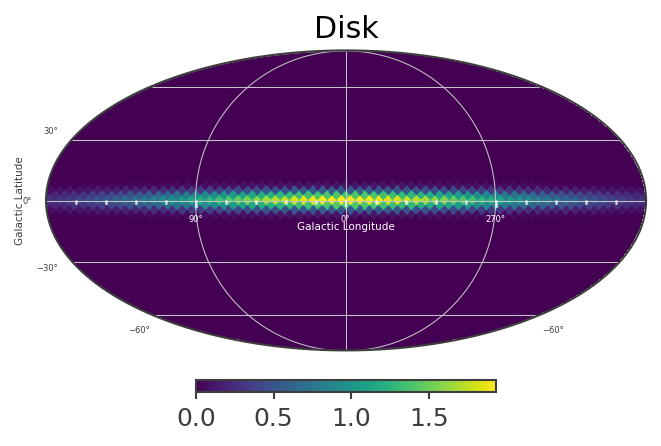

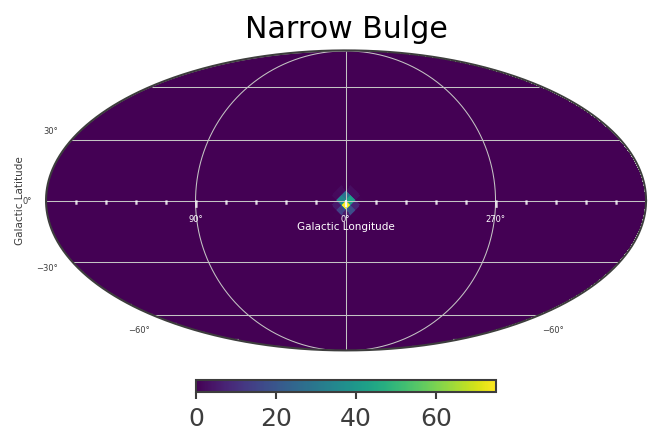

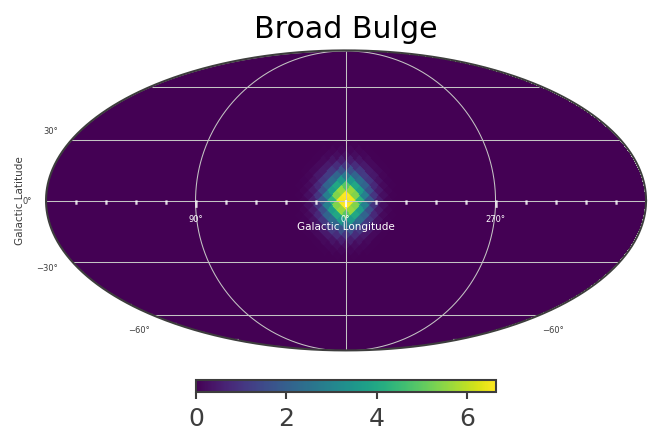

In [16]:
# Plot spatial structure of the extended components
List_of_Maps = [mDisk,mNarrowBulge,mBroadBulge]
List_of_Names = ["Disk","Narrow Bulge","Broad Bulge", ]

for n, m in zip(List_of_Names, List_of_Maps):
    plot, ax = m.plot(ax_kw={"coord": "G"})
    ax.grid()
    lon = ax.coords["glon"]
    lat = ax.coords["glat"]
    lon.set_axislabel("Galactic Longitude", color="white", fontsize=5)
    lat.set_axislabel("Galactic Latitude", fontsize=5)
    lon.display_minor_ticks(True)
    lat.display_minor_ticks(True)
    lon.set_ticks_visible(True)
    lon.set_ticklabel_visible(True)
    lon.set_ticks(color="white", alpha=0.6)
    lat.set_ticks(color="white", alpha=0.6)
    lon.set_ticklabel(color="white", fontsize=4)
    lat.set_ticklabel(fontsize=4)
    lat.set_ticks_visible(True)
    lat.set_ticklabel_visible(True)
    ax.set_title(n)

### 2. Initialize the Source Injector

In [21]:
# Initialize the SourceInjector (using galactic frame for extended sources)
injector = SourceInjector(response_path = response_path, response_frame = "galactic")

### 3. Get the expected counts for the extended source and save to a data file

CPU times: user 10 s, sys: 40.9 s, total: 50.9 s
Wall time: 2min 9s


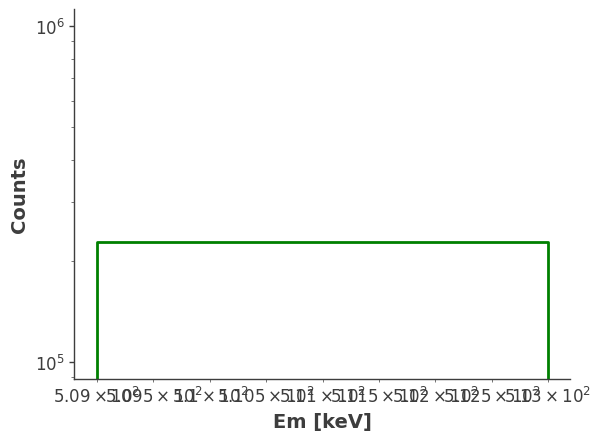

In [22]:
%%time

file_path = "511_thin_disk_injected.h5"

# Check if the file exists and remove it if it does
if os.path.exists(file_path):
    os.remove(file_path)

# Get the data of the injected source
model_injected = injector.inject_model(model = model, make_spectrum_plot = True, data_save_path = file_path)

### 4. Plot the expected counts of all components

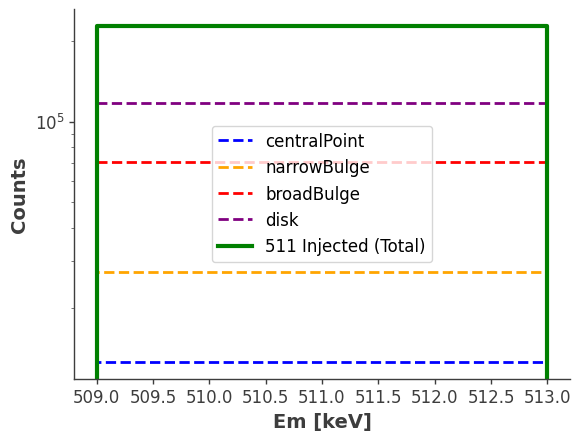

In [23]:
fig, ax = plt.subplots()

# Plot individual counts
names = list(injector.components.keys())
injected_data = list(injector.components.values())

injected_data[0].project("Em").draw(ax=ax, label=names[0], color="blue", linestyle="dashed", linewidth=2)
injected_data[1].project("Em").draw(ax=ax, label=names[1], color="orange", linestyle="dashed", linewidth=2)
injected_data[2].project("Em").draw(ax=ax, label=names[2], color="red", linestyle="dashed", linewidth=2)
injected_data[3].project("Em").draw(ax=ax, label=names[3], color="purple", linestyle="dashed", linewidth=2)

# Plot total expectation
model_injected.project("Em").draw(ax=ax, label="511 Injected (Total)", color="green", linewidth=3)

ax.legend(fontsize=12, frameon=True)
ax.set_xscale("linear")
ax.set_yscale("log")
ax.set_ylabel("Counts", fontsize=14, fontweight="bold")
ax.set_xlabel("Em [keV]", fontsize=14, fontweight="bold")

plt.show()


### (Optional) Compare injected data with simulated data

Load simulated data:

In [24]:
# Read the simulated data
gal_511_sim = Histogram.open(data_dir/"511_thin_disk_3months_binned_data.hdf5")

# remove overflow bins
gal_511_sim_no_overflow = Histogram(edges = gal_511_sim.axes, contents = gal_511_sim.contents, labels = gal_511_sim.axes.labels, track_overflow=False)

gal_511_sim_no_overflow_Em = gal_511_sim_no_overflow.project("Em").todense()

In [28]:
# Compare and plot the simulated and injected counts:

total_expected_counts = float(model_injected.project("Em").todense().contents[0])
simulated_counts = gal_511_sim_no_overflow.project("Em").todense().contents[0]

percentage_diff = 100*(total_expected_counts - simulated_counts)/total_expected_counts

print(f"The difference between the injected and simulates is {percentage_diff}%")

The difference between the injected and simulates is 0.3448856177232999%


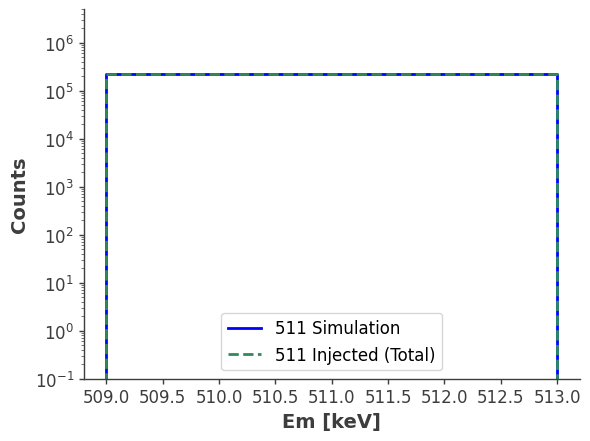

In [29]:
fig, ax = plt.subplots() 

gal_511_sim_no_overflow_Em.draw(ax=ax, label="511 Simulation", color="blue", linewidth=2)
model_injected.project("Em").todense().draw(ax=ax, label="511 Injected (Total)", color="seagreen", linestyle="dashed", linewidth=2)

ax.set_xscale("linear")
ax.set_yscale("log")
ax.set_ylim([1e-1, 5e6])
ax.set_ylabel("Counts", fontsize=14, fontweight="bold")
ax.set_xlabel("Em [keV]", fontsize=14, fontweight="bold")
ax.legend(fontsize=12, frameon=True)

plt.show()